# Airline Review Analysis - In Progress


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import random
import unicodedata
import re
from email.message import EmailMessage
import smtplib
import ssl

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from tqdm.notebook import tqdm
from wordcloud import WordCloud
import eli5

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import metrics

## Data Gathering

Initially, I thought of scrapping the [skytrax](vhttps://www.airlinequality.com/) website, which seemed pretty easy. Before doing that however, a quick search showed me that someone has already done that and the [data uploaded on Kaggle](https://www.kaggle.com/efehandanisman/skytrax-airline-reviews) is fairly recent. 
  
Actually, the fact that it does not include reviews of the last months may be a good thing. As I was browsing skytrax I noticed many recent negative reviews of cancellations, new no-refund policies and lockdown measures, that were caused by Covid-19. Hopefully, this does not reflect the reality of air traveling and we avoid using it in our analysis.  
  
The data is in .xlsx (excel) form. I have avoided converting the file on a .csv so as everyone can download the data from the above Kaggle link and play with the notebook with out having to convert. 

In [58]:
# We drop the aircraft column since it has many NaN values and is not important for our analysis
df = pd.read_excel('datasets/capstone_airline_reviews3.xlsx').drop(['aircraft'], axis=1)

# Many fields will remain empty, but depending on our use case we will accordingly deal with them
df = df.dropna(how='all')

In [59]:
display(df)

,airline,overall,author,review_date,customer_review,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
5,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
7,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
9,Turkish Airlines,1.0,Pooja Jain,6th May 2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131886,Ukraine International,NaN,Yevheniy Kahanovych,21st January 2007,Two domestic flights between Kiev and Lviv las...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131888,Ukraine International,NaN,Helen Lee,15th December 2006,I had a good flight from London to Kiev with U...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131890,Ukraine International,NaN,Andriy Yesypenko,19th May 2006,Kiev - London (Gatwick) in business class (in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131892,Ukraine International,NaN,Volodya Bilotkach,29th April 2006,Several flights - KBP to AMS (3 times one way)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no


This is a first read for our dataset and we have a lot of cleaning up to do. Depending on what data we need for our analysis we must deal with the remaining `NaN` values.  
Also on the `customer_review` field we can see some unicode characters that must be dealt with.

## Most Important Rating

Each review has a number of ratings:
* Food & Beverages
* Inflight Entertainment
* Seat Comfort
* Value For Money
* Cabin Staff Service
* Ground Service

THe ratings have a value from 1 (being the worst) to 5 (being the best). I would like to find which one of the ratings is the most correlated with **if he would recommend the flight**.  
  
Why I consider the *recommend* value as the best reflection of passenger satisfaction?
If a passenger recommends an airline then this means two things. Firstly, that he would promote to a friend/family the airline. Secondly, in future air traveling is probable that hew would again choose the same airline if possible. From a business perspective I believe this makes the *recommend* metric important.  

### Missing Values

As expected many of the reviews have missing values. The quick approach is to drop all the rows with missing values on the columns we need. We will do that and check how many rows we lose.

In [60]:
# Select the columns we need from the df
rate_importance_df = df.iloc[:,-7:].copy()

# We drop the rows that have a NaN value on the recommended column
rate_importance_df = rate_importance_df[rate_importance_df['recommended'].notna()]

print(f"Rows including NaNs: {len(rate_importance_df)}")

rate_importance_df = rate_importance_df.dropna()

print(f"Rows without NaNs: {len(rate_importance_df)}")

Rows including NaNs: 64440
Rows without NaNs: 24596


We lose about 40.000 rows but we still have ~25.000 rows. At least initially I feel that the remaining rows are enough and no other strategy is followed.

### Correlation

We will now calculate the correlation of each rating with if the *recommendation* value.  
  
Our results will not have a simple interpretation, meaning we must take into account that [**correlation does not imply causation**](https://www.tylervigen.com/spurious-correlations).  
  
**Hypothetical scenario:**  
Let's say we found a great correlation (r >0.9) between recommend and inflight entertainment. One might suggest we should make our flights more entertaining, so we install TVs, music, etc. but after some months we do not have the expected increase on ratings.  
With further analysis we discover that the duration of the flight is highly correlated with the inflight entertainment and consequently with the recommend value.  
This means that long haul flights make the passengers more easily bored and tired and we cannot actually do much about this specific issue since [airplanes will not get much faster](https://aviation.stackexchange.com/a/31386).

In [61]:
# Change the yes/no values on recommend column to 1/0
rate_importance_df.recommended = rate_importance_df.recommended.map(dict(yes=1, no=0))

In our case we have a continuous value for the ratings and a binary value (yes/no) for the recommend value. So, we will use the [point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) which is a [special case of Pearson correlation](https://stats.stackexchange.com/a/105553).  
  
Firstly, I will plot some boxplots which will be a pretty good indication if there is any correlation, before quantifying it.

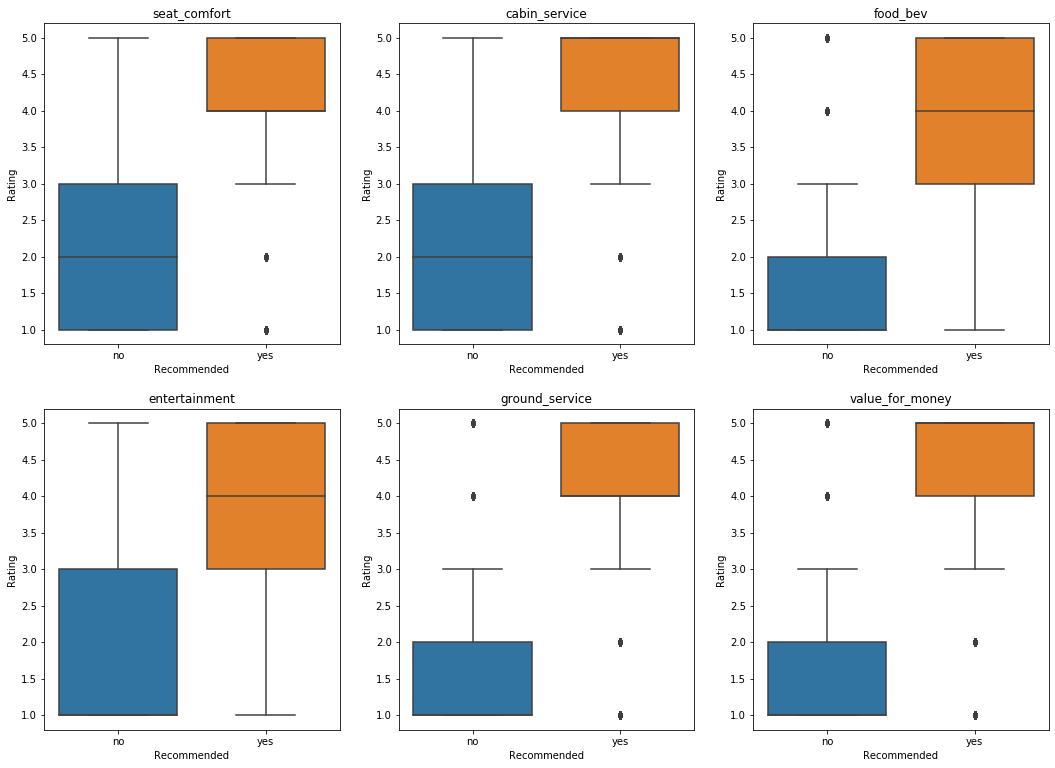

In [62]:
fig = plt.figure(figsize=(18, 13))
plot_index = 1

# Iterate on all the ratings
for which_rating in rate_importance_df.columns[:-1]:
    ax = fig.add_subplot(2, 3, plot_index)
    yes_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 1][which_rating])
    no_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 0][which_rating])

    ax = sns.boxplot(data=[no_ratings, yes_ratings])
    plt.xticks(range(0, 2), ["no", "yes"])
    plt.title(which_rating)
    plt.ylabel("Rating")
    plt.xlabel("Recommended")
    plot_index += 1

plt.show()


On the above plots we can see that all the ratings are correlated. A low rating on any of these, means a "no" on recommendation and vice versa.  
An observation is, that when we are rating **we are biased from our overall experience**. That means if for example the ground_service is bad this might affect our whole view of the flight negatively and be biased when rating the cabin_service etc.  
This can be shown by calculating the correlations between ratings. This shows **correlation "chains"** which do not allow us to be able to distinguish which one is the most important rating.

In [63]:
# Let's calculate the correlation
for which_rating in rate_importance_df.columns[:-1]:
    r, p = stats.pointbiserialr(rate_importance_df.recommended, rate_importance_df[which_rating])
    print(f"{which_rating},\tr = {np.round(r, decimals=3)} with p-value={p}")

seat_comfort,	r = 0.727 with p-value=0.0
cabin_service,	r = 0.745 with p-value=0.0
food_bev,	r = 0.738 with p-value=0.0
entertainment,	r = 0.652 with p-value=0.0
ground_service,	r = 0.751 with p-value=0.0
value_for_money,	r = 0.838 with p-value=0.0


As we can see most of them have the same levels of r-coefficients with entertainment being a bit lower and value for money a bit higher (which is expected since value for money can be considered as a summarizing rating of all the other ratings).  
  
**So by simply looking at the ratings I believe we cannot have a decisive answer on what the airlines should improve.**

## Review Text Processing

Since the above analysis does not have a clear results we will now try to have insights from the text of the reviews. This sounds more helpful, because although the ratings are biased from the overall experience the text should be focused on more specific events.

In [64]:
# Again we will not use all the columns of the df
reviews_df = df[['customer_review', 'recommended']].copy()
reviews_df = reviews_df.dropna()

### Cleaning the Reviews

The reviews as expected contain a lot of non ascii characters. We will review how many of them there are and decide if we should delete them or encode them on ascii.

In [65]:
# Find how many reviews have non-ascii characters
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 28238 out of 64440


Since 28238 is a big number of reviews we will see if we can avoid deleting them. For this reason I will print some random reviews.

In [66]:
for i in range(3):
    rev = reviews_df[mask_nonAscii].iloc[random.sample(range(0, len(reviews_df[mask_nonAscii])), 1)[0]].customer_review
    print(f'{rev}\n\n')

âœ… Trip Verified | Hong Kong to Melbourne. I am writing to complain about the terrible experience that I had on this flight. The seats were more cramped than China Southern Airlines, with which I have flown in the past. The staff only spoke English and not Mandarin Chinese, despite the flight being full of Chinese people. The flight was delayed on the tarmac for three hours, while a fault was investigated. During this time all passengers were crammed into their seats and forced to wait. No food was provided. The cabin was redolent with the smell of aviation gas. Surely it would have been better to let people alight the aircraft while the fault was fixed. The Cathay Pacific brand used to carry some air of quality and distinction in my mind, but no more! Now I consider it to be a cheap junk budget airline that does nothing but disappoint. We will not be flying with Cathay Pacific again, and we will tell all our friends not to as well.


âœ… Trip Verified | Montevideo to Sao Paulo via Ri

After some prints of the reviews that have non-ascii characters we notice some things:
* The non-ascii characters are the first three "âœ"
* Most of the reviews have at the start "Trip Verified |" and then the trip departing and arriving location  
  
We first deal with two above and then count again the non-ascii reviews.

In [67]:
# Split on the first '.' and keep the second part, CARE: This cannot be executed two consecutive times
reviews_df['customer_review'] = reviews_df['customer_review'] .map(
    lambda x: x.split('.', 1)[1] if len(x.split('.', 1)) > 1 
    else None
)


# Drop 26 rows taht ended up not having anythong after their first '.'
reviews_df = reviews_df.dropna()

# Let's again count the non-ascii reviews
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 6458 out of 64414


In [68]:
for i in range(3):
    rev = reviews_df[mask_nonAscii].iloc[random.sample(range(0, len(reviews_df[mask_nonAscii])), 1)[0]].customer_review
    print(f'{rev}\n\n')

 Internet check in was a challange. OS Ticket allows not check in at OS home page. Trial on Germanwings/Eurowings works only with the additional Eurowing booking code. Baggade drop off at OS counter! Lufthansa group is disarranged with Eurowings. The Miles&More booking was not possible, despite booking information on OS ticket purchase? New A320 with winglets. Slightly delayed. Seat comfort acceptable cabin looks clean. Staff was okay but no highlight. The Snack on â€œSmartâ€ seat was the worst tasting sandwich in the last 5 years of my flights.


 My wife, myself and our two young children (2 years and 6 months old respectively) flew last night from London to Abu Dhabi. Had our flight left on time we would have had two hours to catch our connecting flight to Male. This didn't happen and our flight left London roughly two hours later than it should have done which put our connecting flight at risk. That said we had made up some time and landed at 8am with our connecting flight was at 

After again printing some non-ascii reviews we notice that in most cases it is caused by **the apostrophe of [contractions](https://dictionary.cambridge.org/grammar/british-grammar/contractions) (didn't, haven't, etc) not being the ASCII apostrophe**. Since these words do not have a significant meaning that differentiates a positive from a negative review I believe we are allowed to just encode the strings on ASCII.

In [69]:
# Decode all the non-ascii characters from the reviews
reviews_df['customer_review'] = reviews_df['customer_review'].apply(lambda x: x.encode('ascii', 'ignore').\
                                                              strip())

# Go from bytes object to strings
reviews_df['customer_review'] = reviews_df['customer_review'].str.decode("utf-8")

# Final check that there no non-ascii characters in all the reviews
mask_nonAscii = reviews_df['customer_review'].str.len()\
                 .ne(reviews_df['customer_review'].str.encode('ascii',errors = 'ignore').str.len())
print(f'Reviews with non ascii characters: {sum(mask_nonAscii)} out of {len(reviews_df)}')

Reviews with non ascii characters: 0 out of 64414


### Text Normalization

Now we reach the point that we want to see which words seem to be mostly used by the travelers in their reviews. Of course, words like "and", "have", etc will have a big frequency. Using a stopwords dictionary we will remove all of these words that do not offer us any information.

In [70]:
def normalize_review(review):
    """
    We will lower case all the words, remove punctuation, remove stopwords and lemmatize the verbs
    
    Args:
        review (str): The original review (in ascii)
        
    Returns:
        str: The normalized review
    """
    words = nltk.word_tokenize(review)
    
    # Lower words
    lower_words = [word.lower() for word in words]
    
    # Remove punctuation
    words_no_punctuation = []
    for word in lower_words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            words_no_punctuation.append(new_word)
    
    # Remove stopwords
    words_no_stopwords = []
    for word in words_no_punctuation:
        if word not in stopwords.words('english'):
            words_no_stopwords.append(word)
    
    # Lemmatize the verbs (eg ran -> run)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words_no_punctuation]
            
    return " ".join(lemmatized_words)

**Warning**: The below cell takes **16 minutes** in my laptop. In case you want to run the cells below you could first slice the `reviews_df` and select some of the rows, like:
```python
# Random sample of 5000 rows
reviews_df = reviews_df.sample(n=5000)
```
The normalized reviews were cached on my laptop so as to not have to execute this cell again, but the size of the file was way too big for the remote repo.  

In [2]:
tqdm.pandas()

# Normalize all the reviews
reviews_df['customer_review'] = reviews_df['customer_review'].progress_apply(lambda x : normalize_review(x))

# This file is not included on the remote repo due to size
# reviews_df = pd.read_csv('datasets/cache/normalized_reviews.csv', index_col=0)

display(reviews_df)

,customer_review,recommended
1,first time id fly tk i find them very good in ...,yes
3,we make our check in in the airport they take ...,no
5,i fly with this company several time in the pa...,no
7,turkish airlines have consistently maintain it...,yes
9,never book turkish airlines if you be travel t...,no
...,...,...
131886,manual checkin swift plan old 737 but clean an...,no
131888,check in be very fast much quicker than my exp...,no
131890,have fly with uia so many time i be expect tha...,no
131892,mix experience have be yell at once try to cor...,no


### Wordclouds

One quick way to visualize words with high frequencies is to use wordclouds. We will create one for the `recommended="yes"` and one for the `recommended="no"`. 

In [71]:
recomended_yes_text = " ".join(review for review 
                               in reviews_df.loc[reviews_df['recommended'] == "yes"].customer_review)

recomended_no_text = " ".join(review for review 
                               in reviews_df.loc[reviews_df['recommended'] == "no"].customer_review)

wordcloud_yes = WordCloud(background_color="white").generate(recomended_yes_text)
wordcloud_no = WordCloud(background_color="white").generate(recomended_no_text)

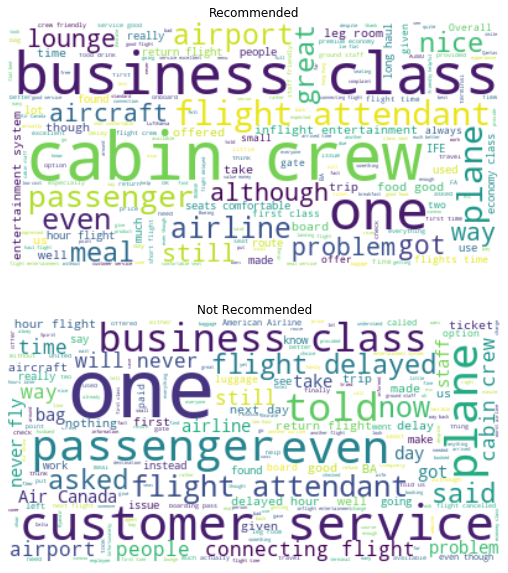

In [72]:
fig = plt.figure(figsize=(18, 10))

ax = fig.add_subplot(2, 1, 1)
plt.title("Recommended")
plt.imshow(wordcloud_yes, interpolation='bilinear')
plt.axis("off")


ax = fig.add_subplot(2, 1, 2)
plt.title("Not Recommended")
plt.imshow(wordcloud_no, interpolation='bilinear')
plt.axis("off")

plt.show()

Observing the not recommended wordcloud we can easily see some expected words like:
* flight delay
* customer sercive
* connect flight
  
However, we must "quantify" the observations of this wordcloud using other techniques.  
  
Before doing that I was curious to find out why word "one" had such a high frequency on both recommended and not recommended reviews.  
The cell below prints reviews containing "one" and we can see that it is just a commonly used word that has no significant meaning in the traveling reviews.

In [75]:
reviews_df_no = reviews_df.loc[reviews_df['recommended'] == "no"].copy()
contains_one = reviews_df_no[reviews_df_no['customer_review'].str.contains("one")]

# Print 2 random reviews containing the word "one"
for i in range(2):
    print(f'{contains_one.iloc[random.sample(range(0, len(contains_one)), 1)[0]].customer_review}\n\n')

United continues to be very slow in upgrading their fleet and providing adequate wifi and entertainment options. When you express dissatisfaction they provide you with an electronic travel certificate. These are difficult keep track of, United does not make any ore in your account that you have these credits, and also difficult to use. I requested to find out what percentage of these travel certificates are actually redeemed and the airline informed me they do not share this information with the public or their customers. United Airlines is not trustworthy and I advise anyone considering flying to fly another airline until United Airlines demonstrates a genuine desire to be transparent and honest with their customers.


I was given a voucher in Melbourne for a hotel layover in Delhi. I misplaced it, and informed the airline before I boarded the flight. They told me not to worry, as the voucher was only for my records and that the hotel at Delhi airport had all of my details. Of course,

## Review Text Classification

One other way of dealing with our problem is to train a classifier to distinguish recommended and NOT recommended reviews. However, we will not use the model to predict future reviews (this is done by the users submitting their review already).  
We will study the weights of the classifiers in order to find the most important features (words).  
  
*We will not focus on ML techniques like hyperparameter tuning and cross-validation since our main focus is not to create an actual predictive model*

In [76]:
# Shuffle the dataset so as our split of train - test is more robust
reviews_df_used = reviews_df.sample(frac=0.1)    # Due to the dataset bein a bit big for my laptop I will use all the reviews
reviews_df_used = reviews_df_used.dropna()

# Split the train and test sets
train_X = reviews_df_used.iloc[:round(0.8 * len(reviews_df_used)), 0]
train_Y = reviews_df_used.iloc[round(0.8 * len(reviews_df_used)):, 0]

test_X = reviews_df_used.iloc[:round(0.8 * len(reviews_df_used)), 1]
test_Y = reviews_df_used.iloc[round(0.8 * len(reviews_df_used)):, 1]

In [5]:
vec = CountVectorizer()
clf = SVC(kernel='linear')    # We have to use linear kernel so as the results are interpretable by ELI5 package
pipe = make_pipeline(vec, clf)
pipe.fit(train_X, test_X);

# notify_me("mikexydas@gmail.com", "Finished", "SVM has finished", password)

Although we do not care about the predictive ability of our model we must evaluate it in order to make sure that the weights have useful meaning to us.

In [6]:
y_pred = pipe.predict(train_Y)
report = metrics.classification_report(test_Y, y_pred, 
    target_names=['yes', 'no'])
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(test_Y, y_pred)))

              precision    recall  f1-score   support

         yes       0.88      0.88      0.88       712
          no       0.86      0.86      0.86       574

    accuracy                           0.87      1286
   macro avg       0.87      0.87      0.87      1286
weighted avg       0.87      0.87      0.87      1286

accuracy: 0.871


As we can see we have some acceptable predicting power with almost no tuning. This allows us to believe that the weights of the words have an actual differentiating meaning between "yes" and "no" reviews.  
  
In order to get which words were more important we will use the ML debugging package called [ELI5](https://github.com/TeamHG-Memex/eli5). 

In [44]:
eli5.sklearn.explain_linear_classifier_weights(clf, vec=vec, top=30, 
                  target_names=['no', 'yes'], targets=['no', 'yes'])

Weight?,Feature
+0.917,thank
+0.820,excellent
+0.784,generous
+0.691,complaints
+0.631,normal
+0.626,efficient
+0.597,wonderful
+0.593,complaint
+0.591,riga
+0.590,accommodate


Most of the words we get on the positive (green) and negative (red) are adjectives that do not have an actual impact on our airline decision making. However, some of the words stand out such as **dirty** and **777s** which is a type of aircraft.  
  
It would be helpful to have context and further analyze the results. For example, the word dirty we speculate that it refers to how clean the cabin is, but maybe some of the reviews use dirty as in the way they were treated.   